In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import json
from urllib.error import URLError,HTTPError
import time
from pathlib import Path
from fastdownload import download_url
from fastai.vision.all import *

In [2]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    print(f'searching for {term}')
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [18]:
# create DIR for notebook and set current DIR
NOTEBOOK_DIR = "Deployment/bearmodel"
Path(NOTEBOOK_DIR).mkdir(parents=True, exist_ok=True)

Search Image on Duck Duck Go for grizzly bear

In [19]:
path = Path(NOTEBOOK_DIR + '/images')

In [20]:
fns = get_image_files(path)
fns

(#79) [Path('Deployment/bearmodel/images/black/b2d8163d-ed6c-4ff7-bca3-0983ae8cac23.jpg'),Path('Deployment/bearmodel/images/black/73141855-1a43-4355-8dde-9dac3b372603.png'),Path('Deployment/bearmodel/images/black/659cceab-c63a-444e-a3e5-4f21fcb76dff.jpg'),Path('Deployment/bearmodel/images/black/a67ccda9-9009-43e5-a8d1-251ae2710507.jpg'),Path('Deployment/bearmodel/images/black/49d31529-662f-48d6-bc66-47501ad3c150.jpg'),Path('Deployment/bearmodel/images/black/0352ea18-9abb-453b-979c-0f12ae53cd31.jpg'),Path('Deployment/bearmodel/images/black/38d42765-2a06-4659-8f85-db58940c18cf.jpg'),Path('Deployment/bearmodel/images/black/21226d27-eee2-4dfe-a137-e37ca206b03c.JPG'),Path('Deployment/bearmodel/images/black/de2ed242-a593-495e-9a90-0a1eddcf7dac.jpg'),Path('Deployment/bearmodel/images/black/0eb070d3-099d-4c0e-a24f-1c186813c62e.JPG')...]

Check for broken image files

In [21]:
failed = verify_images(fns)
failed

(#0) []

Delete broken image files

In [22]:
failed.map(Path.unlink);

In [23]:
get_image_files(path)

(#79) [Path('Deployment/bearmodel/images/black/b2d8163d-ed6c-4ff7-bca3-0983ae8cac23.jpg'),Path('Deployment/bearmodel/images/black/73141855-1a43-4355-8dde-9dac3b372603.png'),Path('Deployment/bearmodel/images/black/659cceab-c63a-444e-a3e5-4f21fcb76dff.jpg'),Path('Deployment/bearmodel/images/black/a67ccda9-9009-43e5-a8d1-251ae2710507.jpg'),Path('Deployment/bearmodel/images/black/49d31529-662f-48d6-bc66-47501ad3c150.jpg'),Path('Deployment/bearmodel/images/black/0352ea18-9abb-453b-979c-0f12ae53cd31.jpg'),Path('Deployment/bearmodel/images/black/38d42765-2a06-4659-8f85-db58940c18cf.jpg'),Path('Deployment/bearmodel/images/black/21226d27-eee2-4dfe-a137-e37ca206b03c.JPG'),Path('Deployment/bearmodel/images/black/de2ed242-a593-495e-9a90-0a1eddcf7dac.jpg'),Path('Deployment/bearmodel/images/black/0eb070d3-099d-4c0e-a24f-1c186813c62e.JPG')...]

In [40]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
    

In [47]:
dls = bears.dataloaders(path)

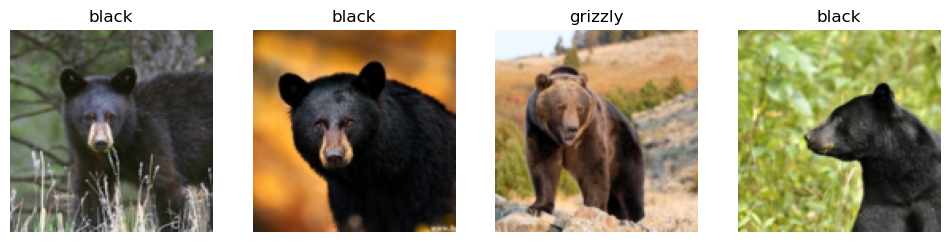

In [50]:
dls.train.show_batch(max_n=4, nrows=1)

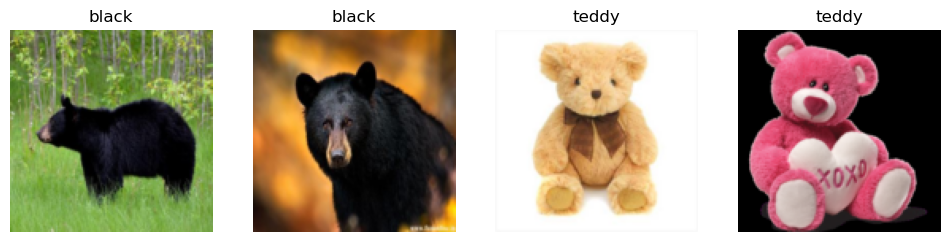

In [52]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

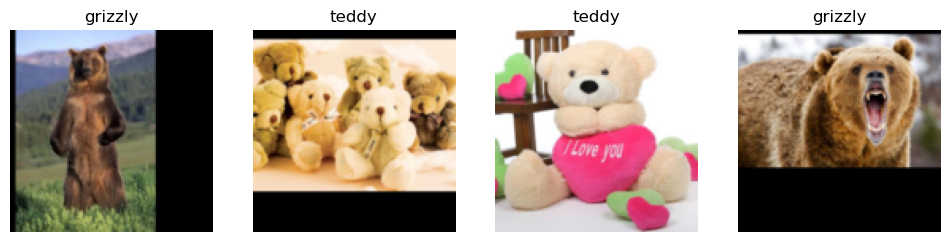

In [53]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

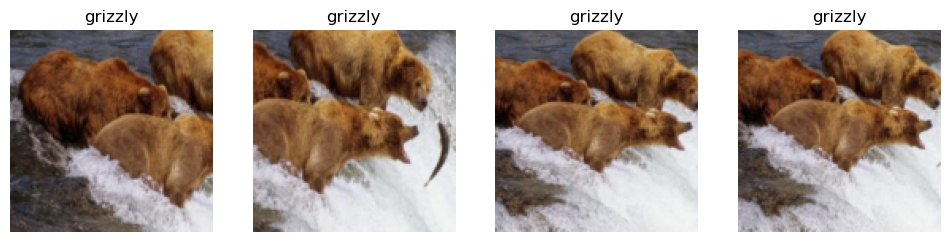

In [55]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

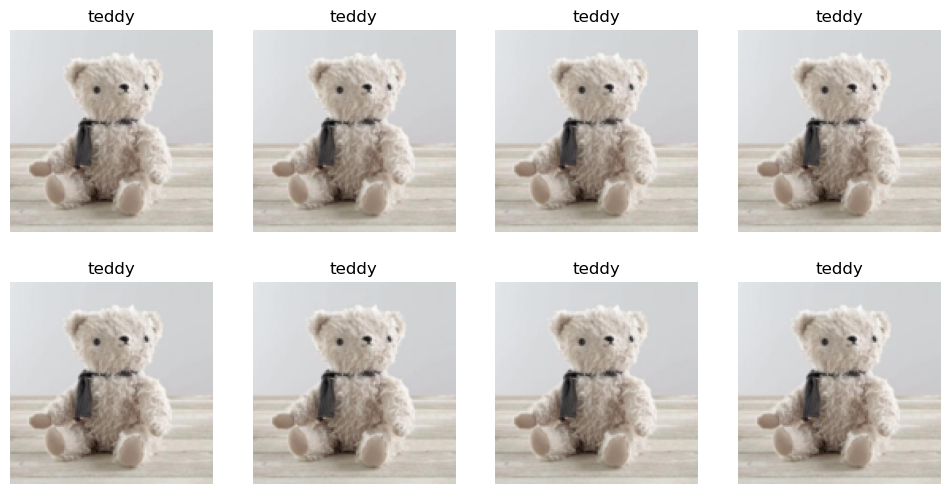

In [56]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

In [57]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [58]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/sachin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sachin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.716352,1.354136,0.666667,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.559581,0.782054,0.200000,00:15
1,1.477403,0.416912,0.200000,00:18
2,1.177543,0.265624,0.133333,00:17
3,0.916605,0.265328,0.066667,00:19


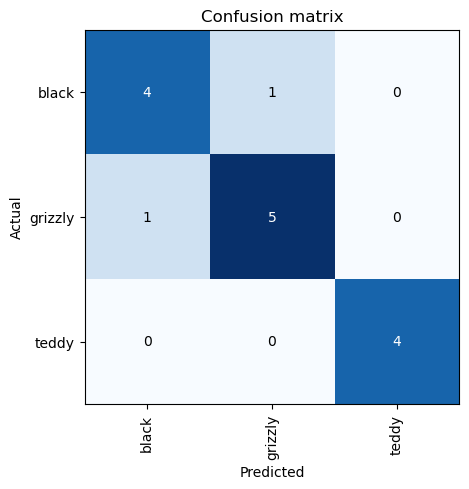

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

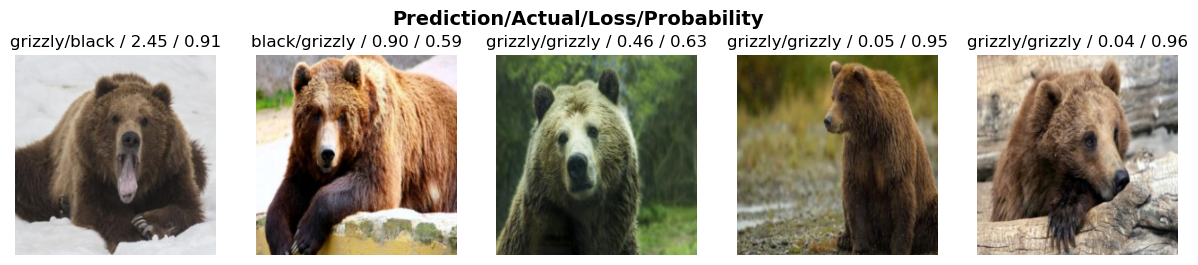

In [35]:
interp.plot_top_losses(5, nrows=1)